In [228]:
import numpy as np 
from sklearn import svm
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
np.random.seed(10)

In [229]:
# generate dummy dataset 
Z = np.random.randint(255, size = (10, 2))
Z = np.append(Z, np.random.choice([-1,1],size = (10,1)), axis = 1)
Z.shape

(10, 3)

In [230]:
Z[-1]

array([ 40, 246,  -1])

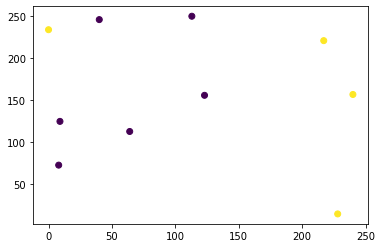

In [231]:
plt.scatter(Z[:,0],Z[:,1], c = Z[:,-1])

In [232]:
# TODO train classifier based on W
def learn_model_h(Z, W):
    clf = svm.SVC(kernel='linear', probability= True,)
    clf.fit(Z[:,:-1], Z[:,-1])
    return clf

In [233]:
# update weights according to classifier h_m
def update_weights(preds, Y, W):
    err = np.sum(W[preds != Y])/ np.sum(W)
    if err == 0:
        return np.zeros(W.shape)
    alpha = 0.5 * np.log((1-err)/err)
    W = W * np.exp(-alpha * Y * preds).reshape(W.shape)
    
    return W/W.sum()
    

In [234]:
# error rate of classifier h_m 
def error_rate(preds, Y):
#     print(h_m.predict(Z[:,:-1]))
    return np.mean(preds != Y)

In [235]:
# calculate total_error rate
# ignore classfier at index except i
def total_error_rate(H_set, Z, except_i):
    # to handle if no h in set preds will not be updated 
    # and will remain zero which is not correct since it will be assumed
    # as predictions and error rate will not be right
    if len(H_set) == 0:
        return sys.maxsize  
    # prediction based on voting of multible h
    preds = np.zeros((1,Z.shape[0]))
    for i, h in enumerate(H_set):
        if except_i != None and i == except_i:
            continue
        preds = preds + (h.predict(Z[:,:-1])).reshape(preds.shape)  
    #calculate error rate of voted prediction    
    return error_rate(np.where(preds[0]>0,1,-1),Z[:,-1]) 

In [236]:
# get index of least significan classifier from classifiers set
def get_least_significant_h(H_set, Z):
    err_list = [total_error_rate(H_set, Z, i) for i in range(len(H_set))]
    return np.argmin(err_list)

In [237]:
def generate_data_set(Z, W):
    idx = np.random.choice(np.arange(0,Z.shape[0], 1),size = Z.shape[0], p = W.flatten())
    return Z[idx]

In [239]:
# float boost procedure
# Z training examples (x1, y1),.....,(xn, yn)
# M_max max No. of weak classifiers
# E total error rate of Strong classifier
# e_star acceptance threshold
def FloatBoost(Z, M_max, E, e_star):
    N = Z.shape[0]
    #initialize weights for each example 
    #shape N x 1
    W = np.ones((N, 1))
    pos_idx = [i for i in range(N) if Z[i][-1] == 1]
    neg_idx = np.setdiff1d(np.arange(0, N-1, 1), pos_idx)
    a = len(pos_idx)
    b = N - a 
    W[pos_idx]= 1/(2*a)
    W[neg_idx]= 1/(2*b)
    W /= W.sum()
    #initialize error rate for each h
    e_min = np.array([e_star for i in range(M_max)])
    # current No. of h trained
    M = -1
    # hypothesises set
    H_set = []
    
    # prev total error rate
    prev_tot_err_rate = sys.maxsize
    
    # Forward Inclusion
    while True: 
        M += 1
        # TODO edit this function to compute h based on W
#         print(W)
        
        h_m = learn_model_h(Z, W)
        #predict values 
        preds = h_m.predict(Z[:,:-1])
        #update weights of examples based on chosen h
        W = update_weights(preds, Z[:, -1], W)
        
        #rate of missclasified points
        err_rate = error_rate(preds, Z[:,-1])
        
#         print(err_rate)
        H_set.extend([h_m])
        
        # update total error rate
        new_err_rate = total_error_rate(H_set, Z, None)
        if prev_tot_err_rate > new_err_rate :
            prev_tot_err_rate = new_err_rate

        #Conditional Exclusion
        while True:
            #get least significant h (removing it causes largest decrease in total error rate)
            least_sign_h_idx = get_least_significant_h(H_set, Z)
            
            temp_err = total_error_rate(H_set,Z, least_sign_h_idx)
#             print(temp_err, least_sign_h_idx)
            #if least_significant h not useful remove it
            if temp_err < prev_tot_err_rate:
#                 print("remove")
                H_set.remove(H_set[least_sign_h_idx])
                prev_tot_err_rate = temp_err
                M -= 1
            else:
#                 print("No significant h")
                break
        print(prev_tot_err_rate)
        # if max h or error rate less than threshold end
        if M == M_max or prev_tot_err_rate < e_star:
            
            break
        Z = generate_data_set(Z,W)
    return H_set
    
H_set = FloatBoost(Z, 10, None, 0.005)
# print(len(H_set))    

0.1
0.1
0.0


In [240]:
# predict class according to classifiers set of float boost algorithm
def predict_fboost(H_set, Z):
    preds = np.zeros((1,Z.shape[0]))
    for h in H_set:
         preds = preds + h.predict(Z[:,:-1])
    return 100 * np.mean((np.where(preds[0] > 0, 1, -1) ==  Z[:,-1])), np.where(preds > 0, 1, -1)

In [241]:
acc , preds = predict_fboost(H_set, Z)
print("Number of classifiers selected:", len(H_set))
print("Total accuracy %", acc)

Number of classifiers selected: 3
Total accuracy % 100.0


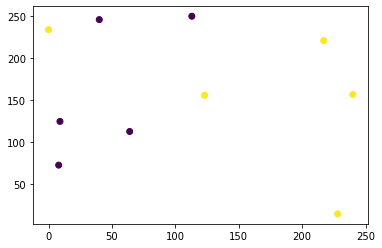

In [215]:
plt.scatter(Z[:,0],Z[:,1], c = preds)

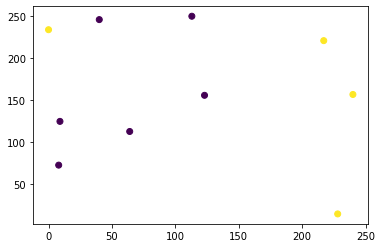

In [216]:
plt.scatter(Z[:,0],Z[:,1], c = Z[:,-1])

In [217]:
preds

array([[-1,  1, -1,  1,  1,  1, -1, -1,  1, -1]])

In [218]:
Z[:,-1]

array([-1,  1, -1, -1,  1,  1, -1, -1,  1, -1])